# COURSE: A deep understanding of deep learning
## SECTION: Metaparameters (activations, optimizers)
### LECTURE: CodeChallenge: Predict sugar
#### TEACHER: Mike X Cohen, sincxpress.com
##### COURSE URL: udemy.com/course/deeplearning_x/?couponCode=202401

In [1]:
# import libraries

# for DL modeling
import torch
import torch.nn as nn
from torch.utils.data import DataLoader,TensorDataset
from sklearn.model_selection import train_test_split

# for number-crunching
import numpy as np
print(np.__version__)
import scipy.stats as stats

# for dataset management
import pandas as pd

# for data visualization
import matplotlib.pyplot as plt
import seaborn as sns

# for counting time
import time

2.1.1


# Import and process the data

In [2]:
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-red.csv"

data_pd = pd.read_csv(url,sep=';')
data_pd

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.700,0.00,1.9,0.076,11.0,34.0,0.99780,3.51,0.56,9.4,5
1,7.8,0.880,0.00,2.6,0.098,25.0,67.0,0.99680,3.20,0.68,9.8,5
2,7.8,0.760,0.04,2.3,0.092,15.0,54.0,0.99700,3.26,0.65,9.8,5
3,11.2,0.280,0.56,1.9,0.075,17.0,60.0,0.99800,3.16,0.58,9.8,6
4,7.4,0.700,0.00,1.9,0.076,11.0,34.0,0.99780,3.51,0.56,9.4,5
...,...,...,...,...,...,...,...,...,...,...,...,...
1594,6.2,0.600,0.08,2.0,0.090,32.0,44.0,0.99490,3.45,0.58,10.5,5
1595,5.9,0.550,0.10,2.2,0.062,39.0,51.0,0.99512,3.52,0.76,11.2,6
1596,6.3,0.510,0.13,2.3,0.076,29.0,40.0,0.99574,3.42,0.75,11.0,6
1597,5.9,0.645,0.12,2.0,0.075,32.0,44.0,0.99547,3.57,0.71,10.2,5


/tmp/ipykernel_1119368/3069717591.py:6: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(),rotation=45)


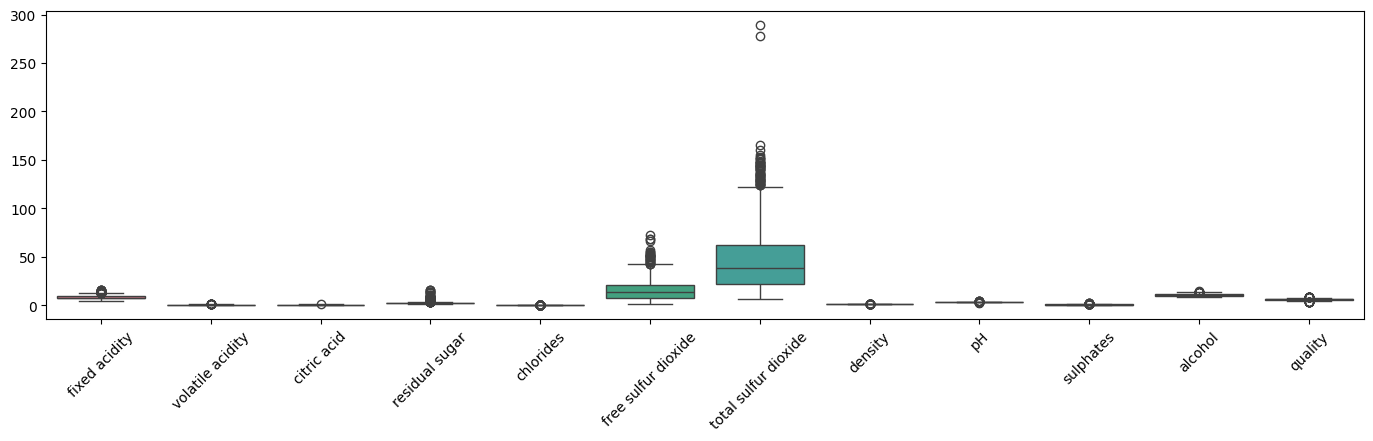

(1597, 12)


/tmp/ipykernel_1119368/3069717591.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_pd[cols2zscore] = data_pd[cols2zscore].apply(stats.zscore)


In [3]:
data_pd.describe()

# plot some data
fig,ax = plt.subplots(1,figsize=(17,4))
ax = sns.boxplot(data=data_pd)
ax.set_xticklabels(ax.get_xticklabels(),rotation=45)
plt.show()

# remove outliers 
data_pd = data_pd[data_pd['total sulfur dioxide']<200]
print(data_pd.shape)

# zscore / normalize
cols2zscore = data_pd.keys()
data_pd[cols2zscore] = data_pd[cols2zscore].apply(stats.zscore)

# Organize the data

torch.Size([1597, 1])
torch.Size([1597, 11])


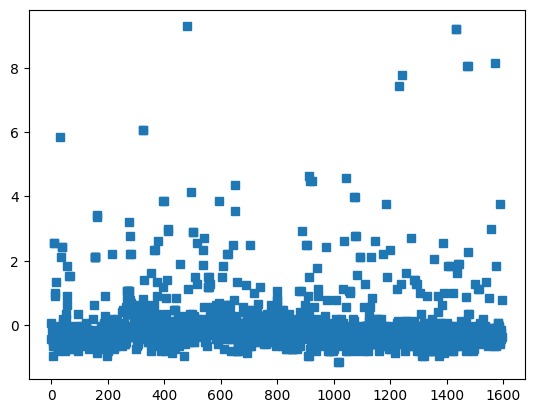

In [4]:
# convert from pandas dataframe to tensor
labels = torch.tensor( data_pd['residual sugar'].values ).float()

data = torch.tensor(data_pd.drop(columns=['residual sugar']).values).float()

labels = labels[:,None]

print(labels.shape)
print(data.shape)

plt.plot(labels,'s')
plt.show()


# Put the data in Tensors

In [5]:
# use scikitlearn to split the data
train_data,test_data, train_labels,test_labels = train_test_split(data, labels, test_size=.1)


# then convert them into PyTorch Datasets (note: already converted to tensors)
train_data = TensorDataset(train_data,train_labels)
test_data  = TensorDataset(test_data,test_labels)


# Construct the model and training plans

In [6]:
# a function that creates the ANN model

def createANewModel():

  # model architecture
  ANN = nn.Sequential(
      nn.Linear(11,64),   # input layer
      nn.ReLU(),         # activation unit
      nn.Linear(64,128),  # hidden layer
      nn.ReLU(),         # activation unit
      nn.Linear(128,128),  # hidden layer
      nn.ReLU(),         # activation unit
      nn.Linear(128,64),  # hidden layer
      nn.ReLU(),         # activation unit
      nn.Linear(64,1),   # output units
        )
  
  # model architecture
  # ANN = nn.Sequential(
  #     nn.Linear(11,16),   # input layer
  #     nn.ReLU(),         # activation unit
  #     nn.Linear(16,32),  # hidden layer
  #     nn.ReLU(),         # activation unit
  #     nn.Linear(32,32),  # hidden layer
  #     nn.ReLU(),         # activation unit
  #     nn.Linear(64,1),   # output units
  #       )

  # loss function
  lossfun = nn.MSELoss()

  # optimizer
  optimizer = torch.optim.SGD(ANN.parameters(),lr=0.01) 

  return ANN,lossfun,optimizer

In [7]:
# train the model

# global parameter
numepochs = 1500

def trainTheModel(ANN, lossfun, optimizer, train_loader, test_loader):

  # initialize accuracies as empties
  training_loss   = []
  test_loss       = []

  start_time = time.time()

  # loop over epochs
  for epochi in range(numepochs):

    ANN.train()

    # loop over training data batches
    batchLoss = []
    for X,y in train_loader:

      # forward pass and loss
      yHat = ANN(X)
      loss = lossfun(yHat,y)

      # backprop
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

      # compute training loss just for this batch
      batchLoss.append( loss.item() )
    # end of batch loop...

    # now that we've trained through the batches, get their average training loss
    training_loss.append( np.mean(batchLoss) )

    ANN.eval()

    # test accuracy
    X,y = next(iter(test_loader)) # extract X,y from test dataloader
    with torch.no_grad(): #deactivates gradient calculation, so less overhead
      predlabels = ANN(X)
    test_loss.append( lossfun(predlabels,y).item() )

    end_time = time.time()

    elapsed_time = end_time - start_time

  print(training_loss)

  # function output
  return training_loss, test_loss, elapsed_time


# Run the model

In [15]:
# create a model
ANNwine,lossfun,optimizer = createANewModel()

# create the temporal dataloaders to test (later will be rewritten)
test_batchsize = 32
train_loader = DataLoader(train_data,batch_size=test_batchsize,shuffle=True)
test_loader  = DataLoader(test_data,batch_size=test_data.tensors[0].shape[0],shuffle=False)

# train the model
training_loss, test_loss, elapsed_time = trainTheModel(ANNwine, lossfun, optimizer, train_loader, test_loader)


[np.float64(0.9810646063751645), np.float64(0.9754958113034566), np.float64(0.9771788862016466), np.float64(0.9675158533785079), np.float64(0.964947443207105), np.float64(0.9611845556232664), np.float64(0.9586648874812655), np.float64(0.9508980813953611), np.float64(0.9432829823758867), np.float64(0.9322116881608963), np.float64(0.9167264411846797), np.float64(0.8953698870208529), np.float64(0.8657701330052482), np.float64(0.8273922029468749), np.float64(0.78775764769978), np.float64(0.7397671673032973), np.float64(0.684554429517852), np.float64(0.6350244969129563), np.float64(0.595587984058592), np.float64(0.5547294579446316), np.float64(0.517966598769029), np.float64(0.4839273308714231), np.float64(0.4520371205276913), np.float64(0.4218364793393347), np.float64(0.4022522042195002), np.float64(0.37968722184499104), np.float64(0.36024603810575273), np.float64(0.3409914587934812), np.float64(0.32462851885292265), np.float64(0.31055684006876416), np.float64(0.30395737787087757), np.float

In [21]:
# Calculate the yHat for the train data
X,y_train = next(iter(train_loader))
with torch.no_grad(): #deactivates gradient calculation, so less overhead
  yHat_train = ANNwine(X)

# Calculate the yHat for the test data
X,y_test = next(iter(test_loader))
with torch.no_grad(): #deactivates gradient calculation, so less overhead
  yHat_test = ANNwine(X)

# correlation between yHat and y
correlation_train = np.corrcoef(yHat_train[:,0],y_train[:,0])
correlation_test = np.corrcoef(yHat_test[:,0],y_test[:,0])

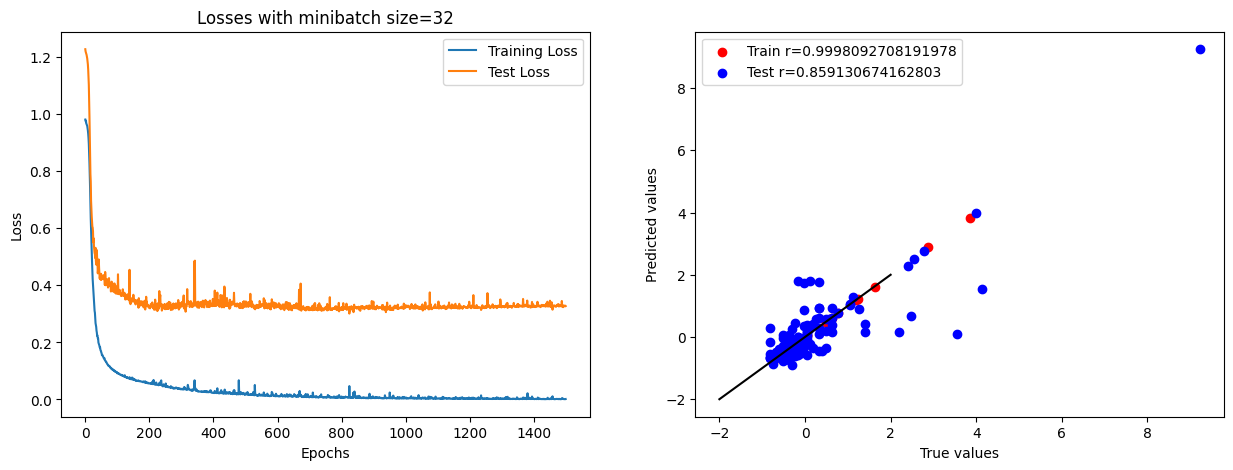

In [22]:
# plot the results
fig, ax = plt.subplots(1, 2, figsize=(15, 5))

ax[0].plot(training_loss)
ax[0].plot(test_loss)
ax[0].legend(['Training Loss', 'Test Loss'])
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Loss')
ax[0].set_title('Losses with minibatch size=' + str(test_batchsize))

# Scatter plot with color and legend
ax[1].scatter(y_train, yHat_train, c='r', label='Train r=' + str(correlation_train[0,1]))
ax[1].scatter(y_test, yHat_test, c='b', label='Test r=' + str(correlation_test[0,1]))
ax[1].plot([-2,2],[-2,2],'k')
ax[1].set_xlabel('True values')
ax[1].set_ylabel('Predicted values')
ax[1].legend()
plt.show()

# Make the data correlation matrix

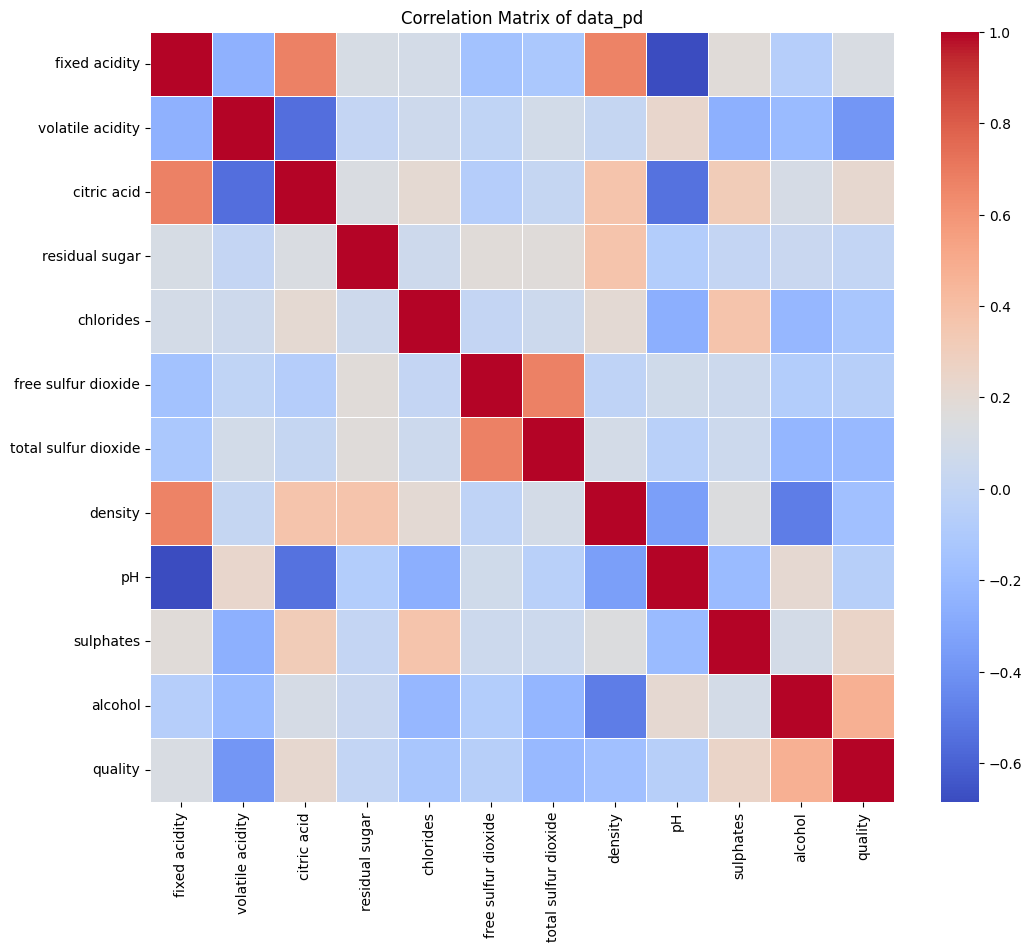

In [24]:
# Calculate the correlation matrix
correlation_matrix = data_pd.corr()

# Plot the correlation matrix
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, cmap='coolwarm', linewidths=0.5)
plt.title('Correlation Matrix of data_pd')
plt.show()

# Let's do the experiment

In [12]:

# we set up the experiment sizes
batch_sizes = np.array([2, 8, 32, 128, 512])
training_loss_results   = np.zeros((numepochs, len(batch_sizes)))
test_loss_results       = np.zeros((numepochs, len(batch_sizes)))
timesResults            = np.zeros(len(batch_sizes))
    
# Smooth the results with a range of 5 values
def smooth(data, range_val=5):
    smoothed_data = np.convolve(data, np.ones(range_val)/range_val, mode='same')
    return smoothed_data

# We do a loop over the batch sizes
for idx, power in enumerate(batch_sizes):
    batchsize = batch_sizes[idx]

    train_loader = DataLoader(train_data,batch_size=int(batchsize),shuffle=True,drop_last=True)
    test_loader  = DataLoader(test_data,batch_size=len(test_data))

    ANNwine,lossfun,optimizer = createANewModel()
    training_loss, test_loss, elapsed_time = trainTheModel(ANNwine, lossfun, optimizer, train_loader, test_loader)

    training_loss_results[:, idx]   = smooth(training_loss)
    test_loss_results[:, idx]       = smooth(test_loss)
    timesResults[idx]               = elapsed_time


[np.float64(0.9231134152074258), np.float64(0.7080406606129097), np.float64(0.5213858246145752), np.float64(0.5511646695276313), np.float64(0.4708465137057862), np.float64(0.46193572102413866), np.float64(0.36281888975521787), np.float64(0.25147279633132014), np.float64(0.242343615503746), np.float64(0.2579287421456856), np.float64(0.2259960192467256), np.float64(0.19318833962431953), np.float64(0.18825469432806616), np.float64(0.15911418268004449), np.float64(0.16047181725295248), np.float64(0.14249576632146096), np.float64(0.13971228857605478), np.float64(0.15011217727406298), np.float64(0.1394113699142531), np.float64(0.16684130120205873), np.float64(0.13715116194056523), np.float64(0.122767315081716), np.float64(0.11387747137981284), np.float64(0.0996742176646491), np.float64(0.10284031330582133), np.float64(0.0947076013793178), np.float64(0.1033094757500632), np.float64(0.09418614748890497), np.float64(0.10298894168803077), np.float64(0.10784945898296915), np.float64(0.10666825356

# Plot the experiment

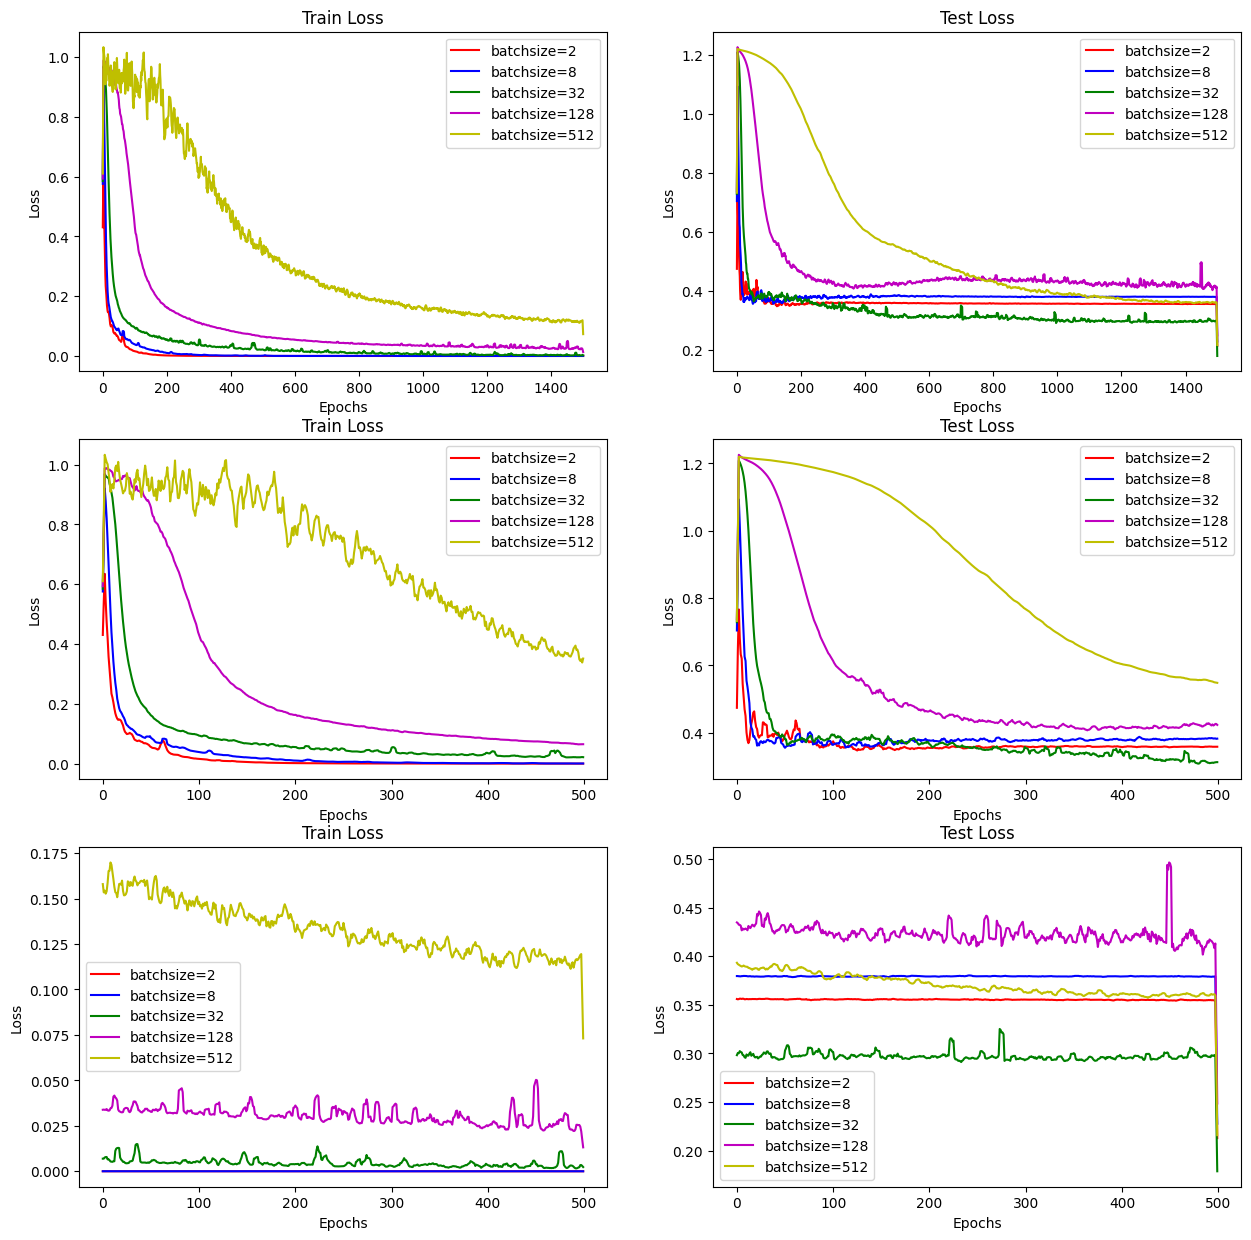

In [13]:
# plot the results
fig, ax = plt.subplots(3, 2, figsize=(15, 15))

ax[0][0].plot(training_loss_results[:, 0], 'r-', label='batchsize=2')
ax[0][0].plot(training_loss_results[:, 1], 'b-', label='batchsize=8')
ax[0][0].plot(training_loss_results[:, 2], 'g-', label='batchsize=32')
ax[0][0].plot(training_loss_results[:, 3], 'm-', label='batchsize=128')
ax[0][0].plot(training_loss_results[:, 4], 'y-', label='batchsize=512')
ax[0][0].set_ylabel('Loss')
ax[0][0].set_xlabel('Epochs')
ax[0][0].set_title('Train Loss')
ax[0][0].legend()

ax[0][1].plot(test_loss_results[:, 0], 'r-', label='batchsize=2')
ax[0][1].plot(test_loss_results[:, 1], 'b-', label='batchsize=8')
ax[0][1].plot(test_loss_results[:, 2], 'g-', label='batchsize=32')
ax[0][1].plot(test_loss_results[:, 3], 'm-', label='batchsize=128')
ax[0][1].plot(test_loss_results[:, 4], 'y-', label='batchsize=512')
ax[0][1].set_ylabel('Loss')
ax[0][1].set_xlabel('Epochs')
ax[0][1].set_title('Test Loss')
ax[0][1].legend()

ax[1][0].plot(training_loss_results[:500, 0], 'r-', label='batchsize=2')
ax[1][0].plot(training_loss_results[:500, 1], 'b-', label='batchsize=8')
ax[1][0].plot(training_loss_results[:500, 2], 'g-', label='batchsize=32')
ax[1][0].plot(training_loss_results[:500, 3], 'm-', label='batchsize=128')
ax[1][0].plot(training_loss_results[:500, 4], 'y-', label='batchsize=512')
ax[1][0].set_ylabel('Loss')
ax[1][0].set_xlabel('Epochs')
ax[1][0].set_title('Train Loss')
ax[1][0].legend()

ax[1][1].plot(test_loss_results[:500, 0], 'r-', label='batchsize=2')
ax[1][1].plot(test_loss_results[:500, 1], 'b-', label='batchsize=8')
ax[1][1].plot(test_loss_results[:500, 2], 'g-', label='batchsize=32')
ax[1][1].plot(test_loss_results[:500, 3], 'm-', label='batchsize=128')
ax[1][1].plot(test_loss_results[:500, 4], 'y-', label='batchsize=512')
ax[1][1].set_ylabel('Loss')
ax[1][1].set_xlabel('Epochs')
ax[1][1].set_title('Test Loss')
ax[1][1].legend()

ax[2][0].plot(training_loss_results[1000:, 0], 'r-', label='batchsize=2')
ax[2][0].plot(training_loss_results[1000:, 1], 'b-', label='batchsize=8')
ax[2][0].plot(training_loss_results[1000:, 2], 'g-', label='batchsize=32')
ax[2][0].plot(training_loss_results[1000:, 3], 'm-', label='batchsize=128')
ax[2][0].plot(training_loss_results[1000:, 4], 'y-', label='batchsize=512')
ax[2][0].set_ylabel('Loss')
ax[2][0].set_xlabel('Epochs')
ax[2][0].set_title('Train Loss')
ax[2][0].legend()

ax[2][1].plot(test_loss_results[1000:, 0], 'r-', label='batchsize=2')
ax[2][1].plot(test_loss_results[1000:, 1], 'b-', label='batchsize=8')
ax[2][1].plot(test_loss_results[1000:, 2], 'g-', label='batchsize=32')
ax[2][1].plot(test_loss_results[1000:, 3], 'm-', label='batchsize=128')
ax[2][1].plot(test_loss_results[1000:, 4], 'y-', label='batchsize=512')
ax[2][1].set_ylabel('Loss')
ax[2][1].set_xlabel('Epochs')
ax[2][1].set_title('Test Loss')
ax[2][1].legend()

plt.show()

# Measure the time it takes to run each batch size

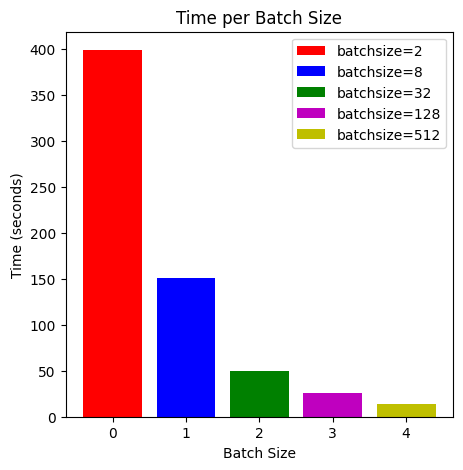

In [14]:
# plot the results
plt.figure(figsize=(5, 5))
bars = plt.bar(range(len(batch_sizes)), timesResults, color=['r', 'b', 'g', 'm', 'y'])

# Add labels to each bar
for bar, size in zip(bars, batch_sizes):
    bar.set_label(f'batchsize={size}')
plt.legend()

# Label the axes and add a title
plt.xlabel('Batch Size')
plt.ylabel('Time (seconds)')
plt.title('Time per Batch Size')

# Show the plot
plt.show()